### PCA with solar twin abundances

The beginnings of this work were done by DWH, originally in the [zinc-robot](https://github.com/megbedell/zinc-robot) repo.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm as cm
from astropy.table import Table
np.random.seed(42)
% matplotlib inline

In [22]:
# Read data
originaldata = Table.read('../data/star_data.fits', format='fits')
sp_names = np.asarray(['CI', 'CH', 'OI', 'NaI', 'MgI', 'AlI', 'SiI', 'SI', 'CaI', 'ScI',
       'ScII', 'TiI', 'TiII', 'VI', 'CrI', 'CrII', 'MnI', 'CoI', 'NiI',
       'CuI', 'ZnI', 'SrI', 'YII', 'ZrII', 'BaII', 'LaII', 'CeII', 'PrII',
       'NdII', 'SmII', 'EuII', 'GdII', 'DyII'])
sp_err_names = np.asarray(["{}_err".format(spn) for spn in sp_names])

In [23]:
# Make plot labels
labels = np.asarray(["[ {} / Fe ]".format(spn) for spn in sp_names])
labels

array(['[ CI / Fe ]', '[ CH / Fe ]', '[ OI / Fe ]', '[ NaI / Fe ]',
       '[ MgI / Fe ]', '[ AlI / Fe ]', '[ SiI / Fe ]', '[ SI / Fe ]',
       '[ CaI / Fe ]', '[ ScI / Fe ]', '[ ScII / Fe ]', '[ TiI / Fe ]',
       '[ TiII / Fe ]', '[ VI / Fe ]', '[ CrI / Fe ]', '[ CrII / Fe ]',
       '[ MnI / Fe ]', '[ CoI / Fe ]', '[ NiI / Fe ]', '[ CuI / Fe ]',
       '[ ZnI / Fe ]', '[ SrI / Fe ]', '[ YII / Fe ]', '[ ZrII / Fe ]',
       '[ BaII / Fe ]', '[ LaII / Fe ]', '[ CeII / Fe ]', '[ PrII / Fe ]',
       '[ NdII / Fe ]', '[ SmII / Fe ]', '[ EuII / Fe ]', '[ GdII / Fe ]',
       '[ DyII / Fe ]'], dtype='<U13')

In [24]:
# make rectangular data                                                                                          
N = len(originaldata) # will be over-written
D = len(sp_names)
data = np.zeros((N, D))
data_err = np.zeros((N, D))
for d, (spn, spne) in enumerate(zip(sp_names, sp_err_names)):
    data[:, d] = originaldata[spn] # "log" b/c these are logarithmic abundances
    data_err[:, d] = originaldata[spne]

In [25]:
# FOR NOW: remove one bad object -- HACK
good = np.isfinite(data)
bad = ~good
mask = np.sum(bad, axis=1) == 0
data = data[mask] # remove one star with one missing abundance
data_err = data_err[mask]
N, D = data.shape # over-write

<span style="color:red">Question: the Sun is still in this data cube. should it be removed?</span>

In [26]:
# make fake data with no structure
mean = np.mean(data, axis=0)
data_fake = mean[None, :] + np.random.normal(size=(N, D)) * data_err

Text(0,0.5,'CH')

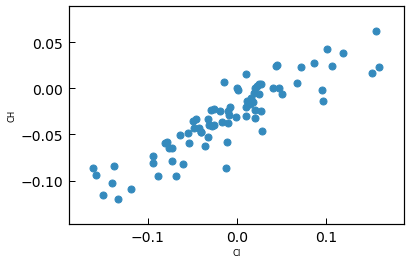

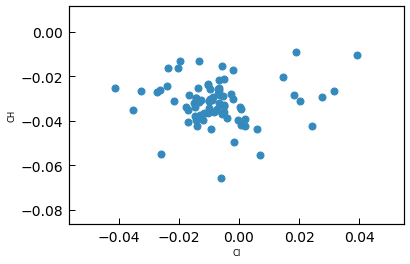

In [27]:
i, j = 0, 1
plt.scatter(data[:, i], data[:, j])
plt.xlabel(sp_names[i])
plt.ylabel(sp_names[j])
plt.figure()
plt.scatter(data_fake[:, i], data_fake[:, j])
plt.xlabel(sp_names[i])
plt.ylabel(sp_names[j])

In [28]:
def pca(data):
    mean = np.mean(data, axis=0)
    dd = data - mean[None, :]
    u, s, vecs = np.linalg.svd(dd, full_matrices=False)
    amps = u * s[None, :]
    print("u:")
    print(u)
    print("s:")
    print(s)
    # reconstrsyuction = mean[None, :] + np.dot(pcas, v)
    # print(data - reconstruction)
    return vecs, amps

In [29]:
# run PCA on the data
vecs, amps = pca(data)
eigenvals = np.sum(amps * amps, axis=0)
# run PCA on the random / fake data
fvecs, famps = pca(data_fake)
feigenvals = np.sum(famps * famps, axis=0)

u:
[[-0.11972206  0.07545946  0.00399617 ... -0.08402431 -0.12443305
  -0.00163341]
 [-0.1720701  -0.00692511 -0.02517542 ...  0.31709401  0.16419131
   0.20710492]
 [-0.1232918   0.14384848 -0.08507783 ... -0.00782944 -0.01222713
   0.01689098]
 ...
 [ 0.05647868 -0.13789729  0.09618253 ... -0.03588101  0.35131625
   0.04009227]
 [-0.07870725  0.07091527  0.01423164 ...  0.23520733 -0.22121285
   0.11068644]
 [ 0.01336922 -0.13674258  0.08302181 ...  0.04006808 -0.03611449
   0.11088796]]
s:
[1.99180161 1.14191677 0.69511543 0.45122914 0.29381037 0.27355423
 0.22767607 0.21168256 0.21054318 0.18103422 0.1674812  0.14939809
 0.13413767 0.12942175 0.10720346 0.10411263 0.08834337 0.06596609
 0.06286356 0.06191005 0.05500811 0.05175033 0.04453103 0.04083993
 0.03657399 0.03496589 0.03054073 0.02724941 0.02518015 0.02402558
 0.01982367 0.01667998 0.01370013]
u:
[[ 6.63607427e-02 -1.32731023e-02 -7.83160676e-02 ...  6.40351519e-02
   2.09343974e-01  8.07833866e-02]
 [-2.63299425e-01  2.430

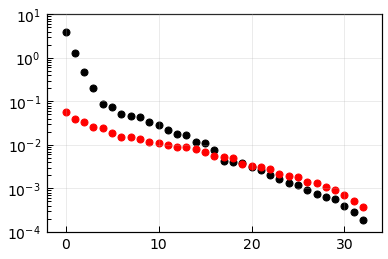

In [32]:
# compare data (black) and fake data (red) PCA amplitudes
plt.scatter(np.arange(len(eigenvals)), eigenvals, color="k")
plt.scatter(np.arange(len(feigenvals)), feigenvals, color="r")
plt.semilogy()
plt.ylim(0.0001, 10.)
plt.grid(alpha=0.3)
plt.savefig('eigenvals.png')

In [31]:
# make a RANDOM rotation of the DATA
# that is, the real data, but rotated into a random basis
data_rotated = np.dot((data - mean[None, :]), fvecs.T)
data.shape, data_rotated.shape, data_fake.shape

((79, 33), (79, 33), (79, 33))

In [13]:
# Make point properties
cmap = cm.get_cmap("viridis")
colors = np.arange(N)[::-1]
# Make other plot properties
s = 5.
alpha = 0.5
foo = 2.5
figsize = (8 * foo, 4 * foo)
xlim = (-0.25, 0.45)

In [14]:
# plotting utility
def plot_data(data, labels):
    f, axlist = plt.subplots(4, 8, sharex=True, sharey=True, figsize=figsize)
    for i, ax in enumerate(axlist.flatten()):
        if (i + 1) >= D:
            break
        if i % 2:
            j, k = i+1, i
        else:
            j, k = i, i+1
        ax.scatter(data[:, j], data[:, k], s=s, c=colors, alpha=alpha, cmap=cmap)
        ax.set_xlabel(labels[j])
        ax.set_ylabel(labels[k])
        ax.set_xlim(xlim)
        ax.set_ylim(xlim)
    f.subplots_adjust(hspace=0.15)
    f.subplots_adjust(wspace=0.15)
    return f

In [15]:
# Plot data in the natural coordinates
f = plot_data(data - mean[None, :], labels)
plt.savefig("natural.png")
plt.close(f)

In [16]:
# Plot data in the PCA coordinates
pca_labels = np.asarray(["eigen {}".format(d) for d in range(D)])
f = plot_data(amps, pca_labels)
plt.savefig("pca.png")
plt.close(f)

In [17]:
# Plot data in randomly rotated coordinates
rand_labels = np.asarray(["random axis {}".format(d) for d in range(D)])
f = plot_data(data_rotated, rand_labels)
plt.savefig("random.png")
plt.close(f)

In [77]:
# Plot top eigenvectors
element_order = np.arange(len(sp_names))
for i in range(11):
    f,ax = plt.subplots(1, figsize=(10,5))
    ax.set_xticks(element_order)
    ax.set_xticklabels(sp_names, fontdict={'fontsize':10}, rotation=35, va="center", position=(0,-0.03))
    ax.scatter(element_order, vecs[i])
    ax.grid(True, alpha=0.3)
    ax.set_title('Eigenvector {0}'.format(i))
    f.savefig('vec{0}.png'.format(i))
    plt.close(f)

In [18]:
def get_vectors(vec1, vec2, K):
    """
    requires that vec1 and vec2 be perpendicular
    """
    dot = np.dot(vec1, vec2)
    vec2perp = vec2 - dot * vec1
    theta_max = np.arccos(dot)
    thetas = np.linspace(0., theta_max, K)
    vecs = np.cos(thetas)[:, None] * vec1[None, :] + np.sin(thetas)[:, None] * vec2perp[None, :]
    return vecs

In [19]:
%matplotlib

Using matplotlib backend: MacOSX


In [19]:
"""
plt.ioff()
plotnum = 0
thisvecs = np.eye(D)
thislabels = np.asarray(["" for d in range(D)])
for d in np.arange(D)[::-1]:
    v1 = np.zeros(D)
    v1[d] = 1
    v2 = vecs[d, :]
    rvecs = get_vectors(v1, v2, 8)
    for i, rvec in enumerate(rvecs):
        fn = "{0:04d}.png".format(plotnum)
        plotnum += 1
        thisvecs[d] = rvec
        thisdata = np.dot((data - mean[None, :]), thisvecs.T)
        thisdata.shape
        f = plot_data(thisdata, thislabels)
        plt.savefig(fn)
        plt.close(f)
"""

'\nplt.ioff()\nplotnum = 0\nthisvecs = np.eye(D)\nthislabels = np.asarray(["" for d in range(D)])\nfor d in np.arange(D)[::-1]:\n    v1 = np.zeros(D)\n    v1[d] = 1\n    v2 = vecs[d, :]\n    rvecs = get_vectors(v1, v2, 8)\n    for i, rvec in enumerate(rvecs):\n        fn = "{0:04d}.png".format(plotnum)\n        plotnum += 1\n        thisvecs[d] = rvec\n        thisdata = np.dot((data - mean[None, :]), thisvecs.T)\n        thisdata.shape\n        f = plot_data(thisdata, thislabels)\n        plt.savefig(fn)\n        plt.close(f)\n'

#### what is the range of Z in this sample?

In [54]:
sp_names

array(['CI', 'CH', 'OI', 'NaI', 'MgI', 'AlI', 'SiI', 'SI', 'CaI', 'ScI',
       'ScII', 'TiI', 'TiII', 'VI', 'CrI', 'CrII', 'MnI', 'CoI', 'NiI',
       'CuI', 'ZnI', 'SrI', 'YII', 'ZrII', 'BaII', 'LaII', 'CeII', 'PrII',
       'NdII', 'SmII', 'EuII', 'GdII', 'DyII'], dtype='<U4')

In [61]:
mask = ~np.isin(sp_names, ['CH','CrII','ScII','TiII'])
sp_names_masked = sp_names[mask]
sp_basenames = [s.strip('I') for s in sp_names_masked]

In [55]:
import periodictable as pt
atomicnumbers = [getattr(pt,s).mass for s in sp_basenames]

In [50]:
from astropy import units as u
def calc_Z(star):
    starmass = star['mass'] * u.solmass
    Zmasses = [10.**(star[s]) for i,s in enumerate(sp_names_masked)]
    return np.sum(star[''])

[12.0107,
 15.9994,
 22.98977,
 24.305,
 26.981538,
 28.0855,
 32.065,
 40.078,
 44.95591,
 47.867,
 50.9415,
 51.9961,
 54.938049,
 58.9332,
 58.6934,
 63.546,
 65.409,
 87.62,
 88.90585,
 91.224,
 137.327,
 138.9055,
 140.116,
 140.90765,
 144.24,
 150.36,
 151.964,
 157.25,
 162.5]